In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
# 한글 글꼴 설정
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] =False

In [18]:
# 데이터 로드
sales_data = pd.read_csv('./csv/sales.csv')
brand_keyword_data = pd.read_csv('./csv/brand_keyword_cnt.csv')
product_info = pd.read_csv('./csv/product_info.csv')
train_data = pd.read_csv('./csv/train.csv')

sales_data.head(), brand_keyword_data.head(), product_info.head(), train_data.head()

(   ID                제품             대분류             중분류             소분류  \
 0   0  B002-00001-00001  B002-C001-0002  B002-C002-0007  B002-C003-0038   
 1   1  B002-00002-00001  B002-C001-0003  B002-C002-0008  B002-C003-0044   
 2   2  B002-00002-00002  B002-C001-0003  B002-C002-0008  B002-C003-0044   
 3   3  B002-00002-00003  B002-C001-0003  B002-C002-0008  B002-C003-0044   
 4   4  B002-00003-00001  B002-C001-0001  B002-C002-0001  B002-C003-0003   
 
           브랜드  2022-01-01  2022-01-02  2022-01-03  2022-01-04  ...  \
 0  B002-00001           0           0           0           0  ...   
 1  B002-00002           0           0           0           0  ...   
 2  B002-00002           0           0           0           0  ...   
 3  B002-00002           0           0           0           0  ...   
 4  B002-00003           0           0           0           0  ...   
 
    2023-03-26  2023-03-27  2023-03-28  2023-03-29  2023-03-30  2023-03-31  \
 0           0           0          

In [19]:
# product_info에 존재하지 않는 제품 제외

product_ids = product_info['제품']

sales_filtered = sales_data[sales_data['제품'].isin(product_ids)]
brand_keyword_cnt_filtered = brand_keyword_data[brand_keyword_data['브랜드'].isin(product_ids)]
train_filtered = train_data[train_data['제품'].isin(product_ids)]

sales_filtered.shape, brand_keyword_cnt_filtered.shape, train_filtered.shape

((10481, 465), (0, 460), (10481, 465))

In [20]:
sales_filtered = pd.read_csv('./csv/sales_filtered.csv')
train_filtered = pd.read_csv('./csv/train_filtered.csv')

In [21]:
# 각 제품의 총 판매량 계산
product_sales = train_filtered.drop(columns=['ID', '대분류', '중분류', '소분류', '브랜드']).set_index('제품')
total_sales_per_product = product_sales.sum(axis=1)

# 총 판매량 기준 상위 5개 제품 월별 판매량 추이
top_5_products = total_sales_per_product.nlargest(5).index

top_5_sales = product_sales.loc[top_5_products].T
top_5_sales.index = pd.to_datetime(top_5_sales.index)

top_5_sales_monthly = top_5_sales.resample('ME').sum()

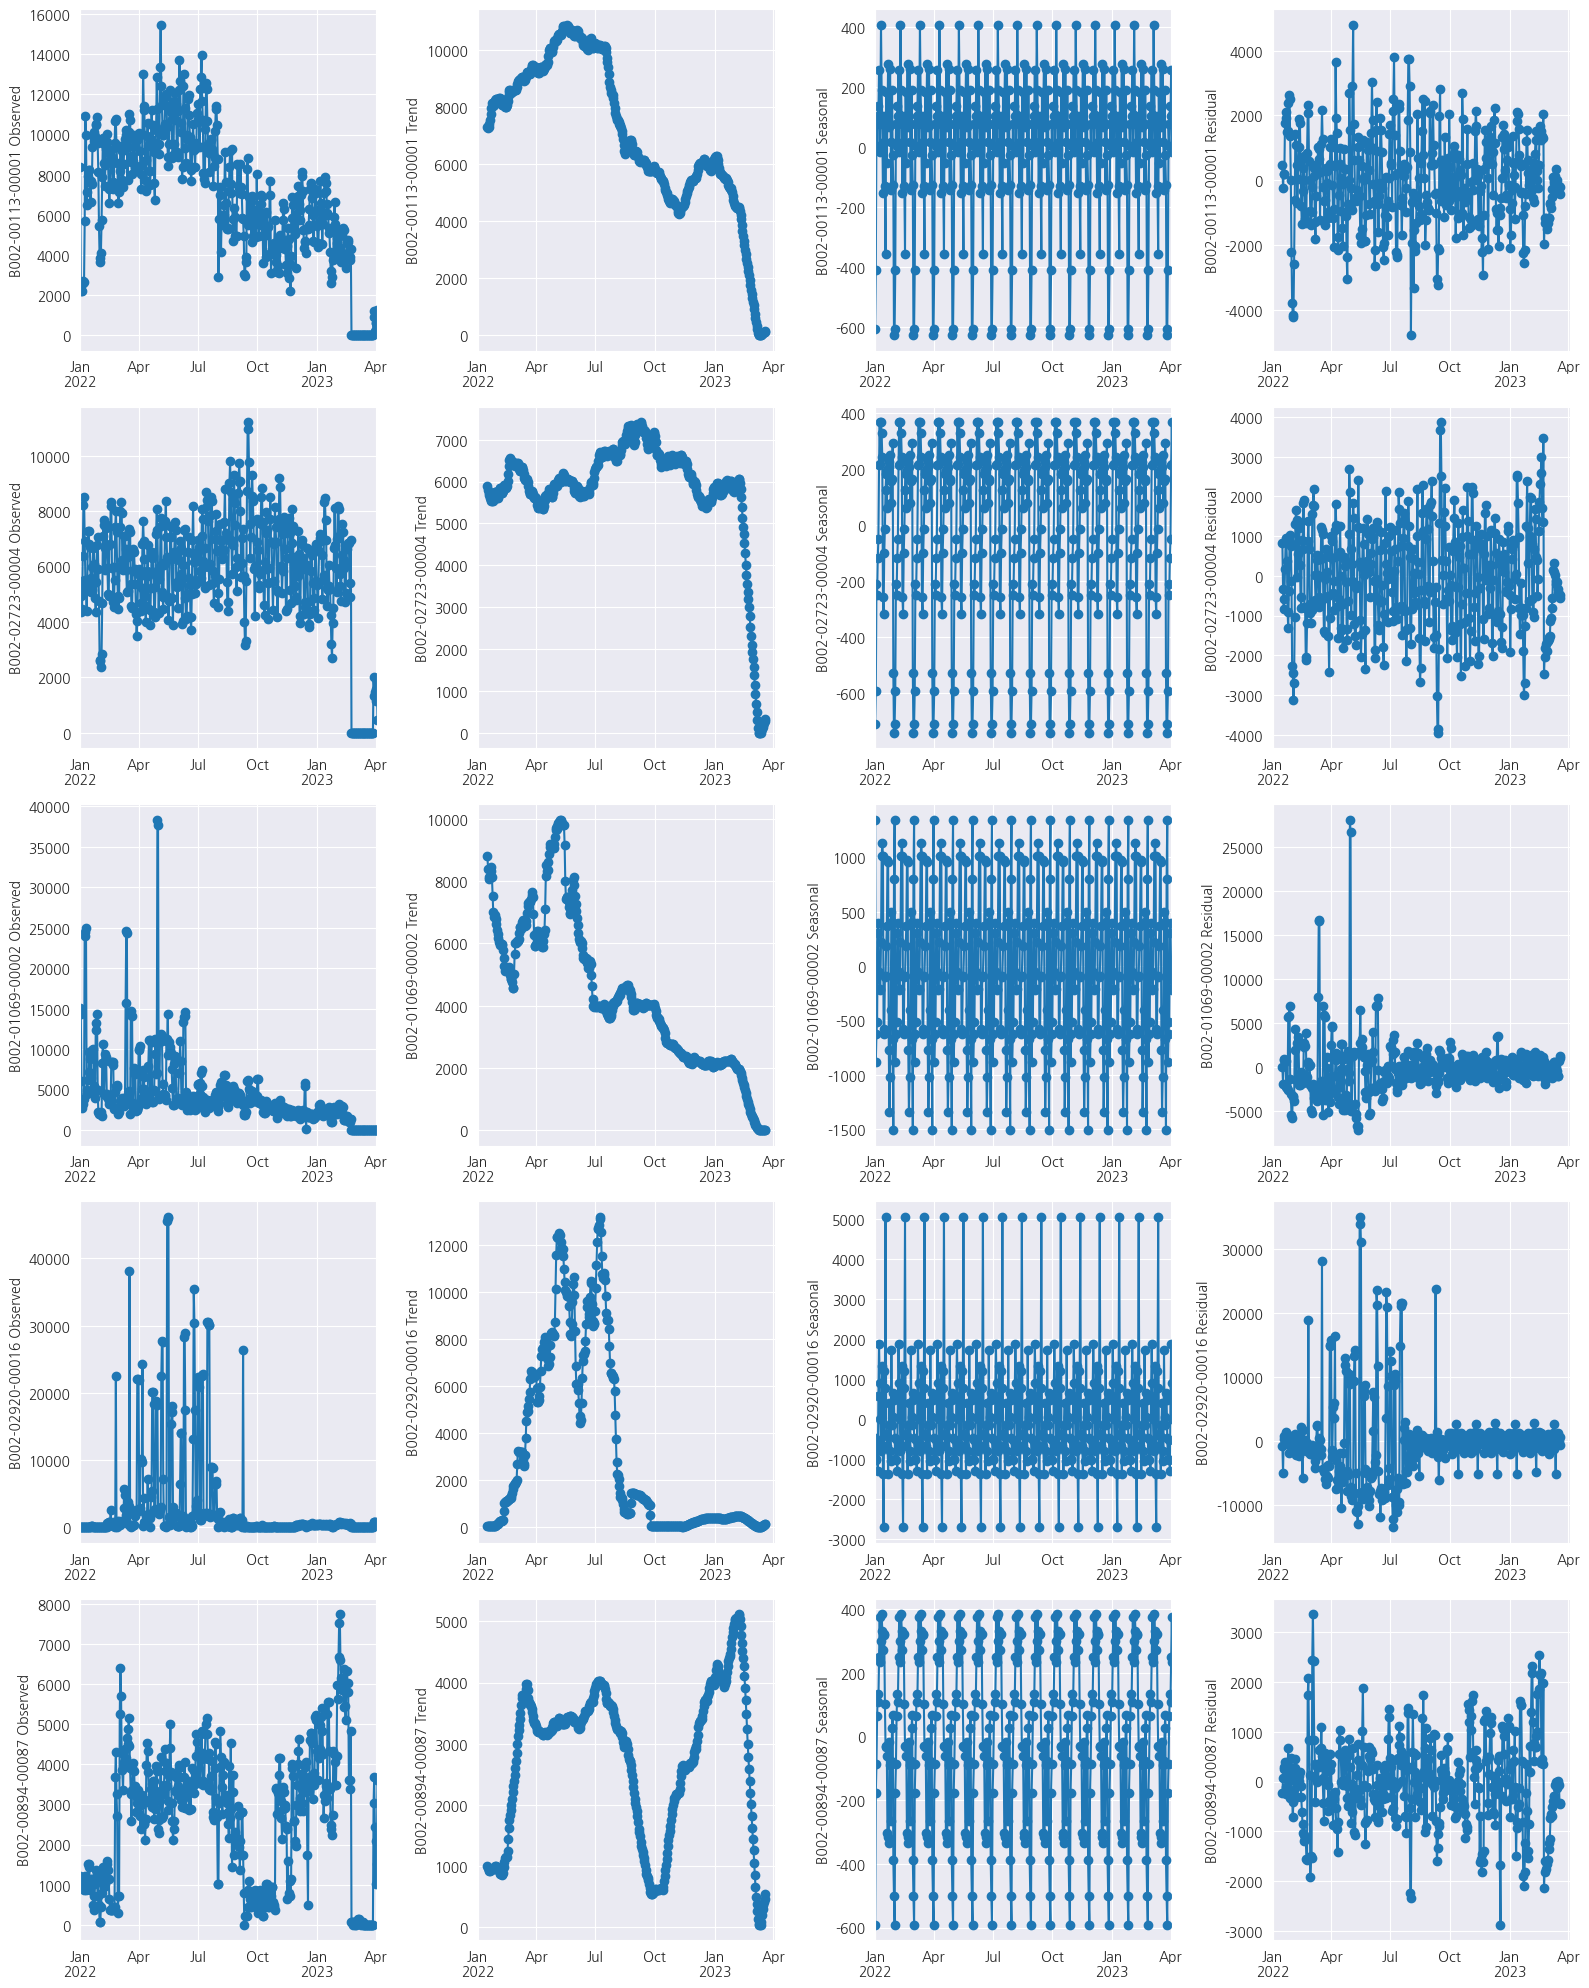

In [22]:
decompositions = {}
residuals = {}
for product in top_5_products:
    decompositions[product] = seasonal_decompose(top_5_sales[product], model='additive', period=30)
    residuals[product] = decompositions[product].resid.dropna()
    
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
for i, product in enumerate(top_5_products):
    decompositions[product].observed.plot(ax=axes[i, 0], marker='o')
    axes[i, 0].set_ylabel(f'{product} Observed')
    decompositions[product].trend.plot(ax=axes[i, 1], marker='o')
    axes[i, 1].set_ylabel(f'{product} Trend')
    decompositions[product].seasonal.plot(ax=axes[i, 2], marker='o')
    axes[i, 2].set_ylabel(f'{product} Seasonal')
    decompositions[product].resid.plot(ax=axes[i, 3], marker='o')
    axes[i, 3].set_ylabel(f'{product} Residual')
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd

# 데이터 로드
train_filtered = pd.read_csv('./csv/train_filtered.csv')

# 필요한 열만 선택
train_filtered = train_filtered.drop(columns=['ID', '대분류', '중분류', '소분류', '브랜드'])

# '제품' 열을 인덱스로 설정
train_filtered = train_filtered.set_index('제품').T

# 열 이름을 날짜 형식으로 변환
train_filtered.index = pd.to_datetime(train_filtered.index)

# 상위 5개 제품 선택
top_5_products = ['B002-00113-00001', 'B002-02723-00004', 'B002-01069-00002', 'B002-02920-00016', 'B002-00894-00087']

# 계절별 판매량 변동률 계산 함수
def calculate_seasonal_changes(product_id):
    product_sales = train_filtered[product_id]
    
    spring_sales = product_sales[product_sales.index.month.isin([3, 4, 5])].sum()
    summer_sales = product_sales[product_sales.index.month.isin([6, 7, 8])].sum()
    fall_sales = product_sales[product_sales.index.month.isin([9, 10, 11])].sum()
    winter_sales = product_sales[product_sales.index.month.isin([12, 1, 2])].sum()
    
    spring_to_summer = ((summer_sales - spring_sales) / spring_sales) * 100 if spring_sales != 0 else float('nan')
    summer_to_fall = ((fall_sales - summer_sales) / summer_sales) * 100 if summer_sales != 0 else float('nan')
    fall_to_winter = ((winter_sales - fall_sales) / fall_sales) * 100 if fall_sales != 0 else float('nan')
    winter_to_spring = ((spring_sales - winter_sales) / winter_sales) * 100 if winter_sales != 0 else float('nan')
    
    return {
        '제품': product_id,
        '봄->여름': spring_to_summer,
        '여름->가을': summer_to_fall,
        '가을->겨울': fall_to_winter,
        '겨울->봄': winter_to_spring
    }

# 모든 상위 5개 제품에 대해 계절별 판매량 변동률 계산
seasonal_changes = [calculate_seasonal_changes(product) for product in top_5_products]

# 결과를 데이터프레임으로 변환
seasonal_changes_df = pd.DataFrame(seasonal_changes)


seasonal_changes_df


,제품,봄->여름,여름->가을,가을->겨울,겨울->봄
0,B002-00113-00001,-8.826839,-41.304827,89.539815,-1.410617
1,B002-02723-00004,7.479801,2.877079,37.526787,-34.239180
2,B002-01069-00002,-37.866967,-33.296749,108.867617,15.520574
3,B002-02920-00016,-14.349706,-93.300105,83.821043,847.999151
4,B002-00894-00087,-5.769575,-57.139193,215.700049,-21.571509


In [24]:
# 잔차의 통계치 계산
residual_stats = {}
for product, resid in residuals.items():
    residual_stats[product] = {
        'Mean': np.mean(resid),
        'Std Dev': np.std(resid),
        'Min': np.min(resid),
        'Max': np.max(resid)
    }

residual_stats_df = pd.DataFrame(residual_stats).T
print(residual_stats_df)

                       Mean      Std Dev           Min           Max
B002-00113-00001  13.595198  1395.656624  -4789.692897   4796.707103
B002-02723-00004 -10.443048  1303.351188  -3948.107333   3867.348063
B002-01069-00002 -15.079915  3122.565225  -7108.698963  28163.762942
B002-02920-00016  -6.557413  6365.680685 -13454.376460  35096.378143
B002-00894-00087  -4.293095   868.290986  -2874.437540   3358.052143
